# Exercise project 2 – ANN for Classification (Obesity dataset)

In this project, I built an artificial neural network (ANN) for multi-class classification to predict an individual's obesity status based on lifestyle, nutrition, and biometric features.

https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import seaborn as sns
from tqdm.keras import TqdmCallback
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

### Step 1: Data analysis and visualisations

In [ ]:
folder_path = "/content/drive/MyDrive/deeplearning2024_VincenzinaSoos/ex_2/"
os.chdir(folder_path)

In [ ]:
df = pd.read_csv('data/obesity.csv')

In [ ]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


### Step 2: Data pre-processing

Here I was confused what the column names meant so I asked ChatGPT 4o to explain to me and convert the abbrivations (I shortened them)

In [ ]:
column_mapping = {
    "family_history_with_overweight": "family_history",
    "FAVC": "fav_veg_fruit",
    "FCVC": "veg_freq",
    "NCP": "meals_per_day",
    "CAEC": "snack_freq",
    "SMOKE": "smoking",
    "CH2O": "water_intake",
    "SCC": "kcal_monitor",
    "FAF": "activity_freq",
    "TUE": "tech_time",
    "CALC": "alcohol_use",
    "MTRANS": "transport_mode",
    "NObeyesdad": "obesity_status"
}

df.rename(columns=column_mapping, inplace=True)
df.columns = df.columns.str.lower()

In [ ]:
df.head(2)

,gender,age,height,weight,family_history,fav_veg_fruit,veg_freq,meals_per_day,snack_freq,smoking,water_intake,kcal_monitor,activity_freq,tech_time,alcohol_use,transport_mode,obesity_status
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight


In [ ]:
columns_to_convert = ['veg_freq', 'meals_per_day', 'water_intake', 'activity_freq', 'tech_time', 'age']
df[columns_to_convert] = df[columns_to_convert].astype(int)

I looked at the data types and saw that several columns were still in object format, so I used LabelEncoder to convert everything into numerical form. I checked for missing values and converted the cleaned-up DataFrame into integers where appropriate.

In [ ]:
df.dtypes

,0
gender,object
age,int64
height,float64
weight,float64
family_history,object
fav_veg_fruit,object
veg_freq,int64
meals_per_day,int64
snack_freq,object
smoking,object


In [ ]:
# looking at non numeric columns and unique values
non_numeric_columns = df.select_dtypes(exclude=['number'])
unique_values = {col: non_numeric_columns[col].unique() for col in non_numeric_columns.columns}
for column, values in unique_values.items():
    print(f"Unique values in '{column}': {values}")

Unique values in 'gender': ['Female' 'Male']
Unique values in 'family_history': ['yes' 'no']
Unique values in 'fav_veg_fruit': ['no' 'yes']
Unique values in 'snack_freq': ['Sometimes' 'Frequently' 'Always' 'no']
Unique values in 'smoking': ['no' 'yes']
Unique values in 'kcal_monitor': ['no' 'yes']
Unique values in 'alcohol_use': ['no' 'Sometimes' 'Frequently' 'Always']
Unique values in 'transport_mode': ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
Unique values in 'obesity_status': ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


In [ ]:
df.head()

,gender,age,height,weight,family_history,fav_veg_fruit,veg_freq,meals_per_day,snack_freq,smoking,water_intake,kcal_monitor,activity_freq,tech_time,alcohol_use,transport_mode,obesity_status
0,Female,21,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II


In [ ]:
# Columns to encode
columns_to_encode = ['gender', 'family_history', 'fav_veg_fruit', 'snack_freq',
                     'smoking', 'kcal_monitor', 'alcohol_use', 'transport_mode', 'obesity_status']

# Encode and store mappings
encoders = {}
for col in columns_to_encode:
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col])

# Save mappings for decoding later
mappings = {col: dict(zip(encoders[col].classes_, range(len(encoders[col].classes_))))
            for col in encoders}

In [ ]:
df.describe()

,gender,age,height,weight,family_history,fav_veg_fruit,veg_freq,meals_per_day,snack_freq,smoking,water_intake,kcal_monitor,activity_freq,tech_time,alcohol_use,transport_mode,obesity_status
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,0.505921,23.972525,1.701677,86.586058,0.817622,0.883941,2.213169,2.523449,1.859308,0.020843,1.712459,0.045476,0.734723,0.381336,2.268593,2.365230,3.015632
std,0.500083,6.308664,0.093305,26.191172,0.386247,0.320371,0.599397,0.830288,0.468543,0.142893,0.598760,0.208395,0.832812,0.582536,0.515498,1.261423,1.952090
min,0.000000,14.000000,1.450000,39.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,1.630000,65.473343,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,3.000000,1.000000
50%,1.000000,22.000000,1.700499,83.000000,1.000000,1.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000,1.000000,0.000000,2.000000,3.000000,3.000000
75%,1.000000,26.000000,1.768464,107.430682,1.000000,1.000000,3.000000,3.000000,2.000000,0.000000,2.000000,0.000000,1.000000,1.000000,3.000000,3.000000,5.000000
max,1.000000,61.000000,1.980000,173.000000,1.000000,1.000000,3.000000,4.000000,3.000000,1.000000,3.000000,1.000000,3.000000,2.000000,3.000000,4.000000,6.000000


In [ ]:
df.head(2)

,gender,age,height,weight,family_history,fav_veg_fruit,veg_freq,meals_per_day,snack_freq,smoking,water_intake,kcal_monitor,activity_freq,tech_time,alcohol_use,transport_mode,obesity_status
0,0,21,1.62,64.0,1,0,2,3,2,0,2,0,0,1,3,3,1
1,0,21,1.52,56.0,1,0,3,3,2,1,3,1,3,0,2,3,1


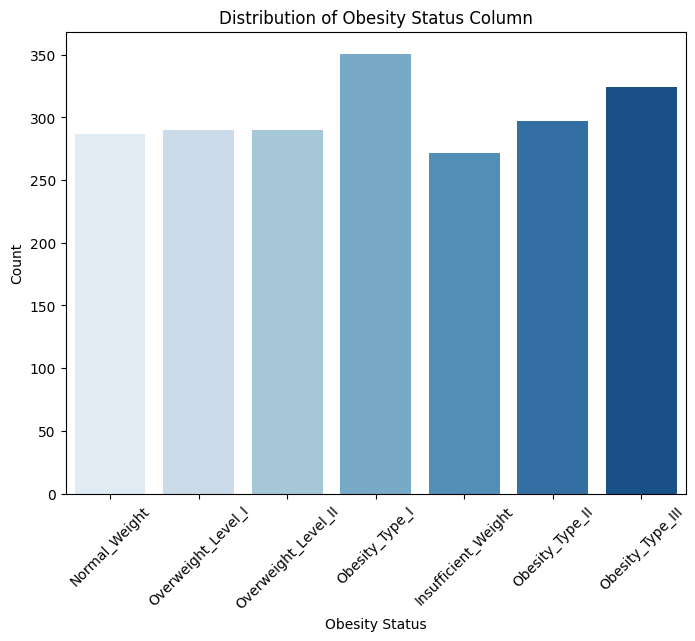

In [ ]:
plt.figure(figsize=(8, 6))
decoded_labels = encoders['obesity_status'].inverse_transform(df['obesity_status'])
sns.countplot(x=decoded_labels, palette="Blues")
plt.title("Distribution of Obesity Status Column")
plt.xlabel("Obesity Status")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

I split the dataset into training and test sets.

In [ ]:
X = df.drop(columns=['obesity_status'])
y = df['obesity_status']

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
df.head(2)

,gender,age,height,weight,family_history,fav_veg_fruit,veg_freq,meals_per_day,snack_freq,smoking,water_intake,kcal_monitor,activity_freq,tech_time,alcohol_use,transport_mode,obesity_status
0,0,21,1.62,64.0,1,0,2,3,2,0,2,0,0,1,3,3,1
1,0,21,1.52,56.0,1,0,3,3,2,1,3,1,3,0,2,3,1


### Step 3: Model Architecture

In [ ]:
Input = tf.keras.layers.InputLayer
Dense = tf.keras.layers.Dense
Sequential = tf.keras.models.Sequential
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
input_shape = X.shape[1]
num_classes = len(np.unique(y))

Here, I built a fairly basic ANN with two hidden layers (16 and 8 neurons), both using ReLU activations, and a final softmax layer since this is a multi-class problem. I used EarlyStopping to prevent overfitting and added a callback to display progress during training.

In [ ]:
model = Sequential()

# Add the input layer
model.add(Input(shape=(input_shape,)))
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

# Compile the model
model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summarize the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 471 (1.84 KB)

 Trainable params: 471 (1.84 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x=X_train, y=y_train, epochs=500, validation_split=0.1,
          verbose=0,
          callbacks=[early_stopping, TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

### Step 4: Model Evaluation

In [ ]:
# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [ ]:
# Convert integer predictions and true labels back to original labels
y_test_real = encoders['obesity_status'].inverse_transform(y_test)
y_pred_real = encoders['obesity_status'].inverse_transform(y_pred)

<Figure size 1000x800 with 0 Axes>

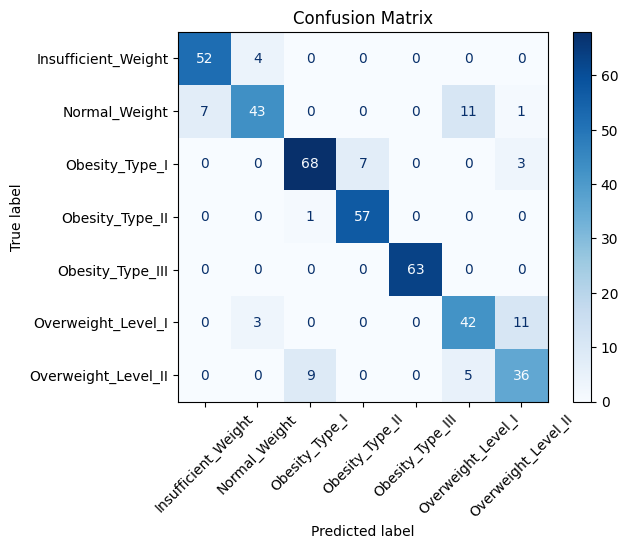

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_real, y_pred_real)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=encoders['obesity_status'].classes_)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict the classes on the test set
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

Test Loss: 0.3282874822616577
Test Accuracy: 0.8534278869628906
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        56
           1       0.86      0.69      0.77        62
           2       0.87      0.87      0.87        78
           3       0.89      0.98      0.93        58
           4       1.00      1.00      1.00        63
           5       0.72      0.75      0.74        56
           6       0.71      0.72      0.71        50

    accuracy                           0.85       423
   macro avg       0.85      0.85      0.85       423
weighted avg       0.85      0.85      0.85       423



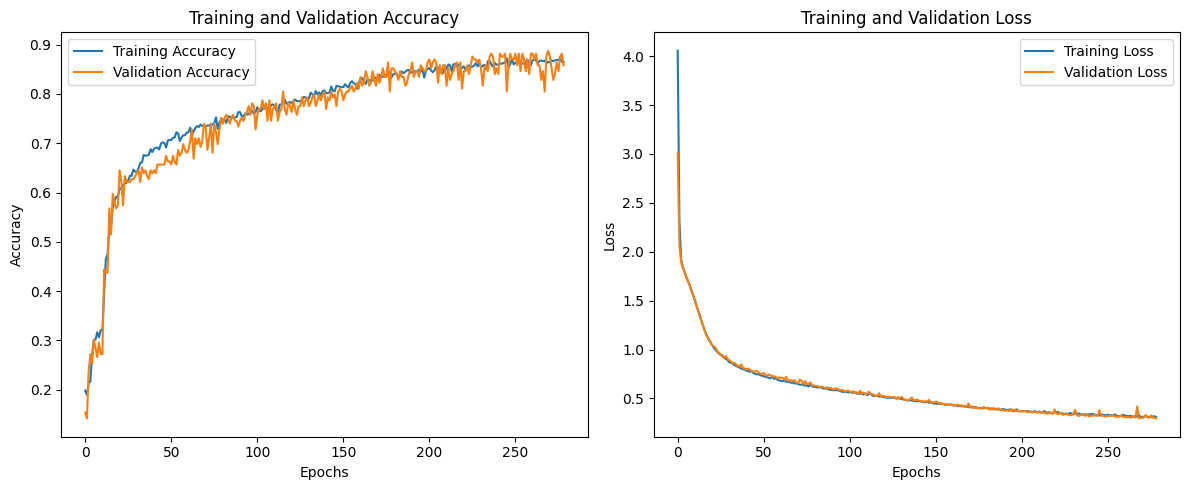

In [ ]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Step 5: Predictions

In [ ]:
new_data = pd.DataFrame({
    'gender': [encoders['gender'].transform(['Female'])[0]],
    'age': [35],
    'height': [1.70],
    'weight': [90.0],
    'family_history': [encoders['family_history'].transform(['yes'])[0]],
    'fav_veg_fruit': [encoders['fav_veg_fruit'].transform(['no'])[0]],
    'veg_freq': [2],
    'meals_per_day': [3],
    'snack_freq': [encoders['snack_freq'].transform(['Sometimes'])[0]],
    'smoking': [encoders['smoking'].transform(['no'])[0]],
    'water_intake': [3],
    'kcal_monitor': [encoders['kcal_monitor'].transform(['no'])[0]],
    'activity_freq': [2],
    'tech_time': [4],
    'alcohol_use': [encoders['alcohol_use'].transform(['Sometimes'])[0]],
    'transport_mode': [encoders['transport_mode'].transform(['Automobile'])[0]]
})

# Predict the obesity status for the new data
new_pred_prob = model.predict(new_data)
new_pred_class = np.argmax(new_pred_prob, axis=1)
new_pred_label = encoders['obesity_status'].inverse_transform(new_pred_class)
print("\nPrediction for New Imaginary Data:")
print("Input Values:")
display(new_data)
print("Predicted Obesity Status:", new_pred_label[0])
print("Prediction Probabilities:", new_pred_prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step

Prediction for New Imaginary Data:
Input Values:


,gender,age,height,weight,family_history,fav_veg_fruit,veg_freq,meals_per_day,snack_freq,smoking,water_intake,kcal_monitor,activity_freq,tech_time,alcohol_use,transport_mode
0,0,35,1.7,90.0,1,0,2,3,2,0,3,0,2,4,2,0


Predicted Obesity Status: Obesity_Type_I
Prediction Probabilities: [[1.8613591e-23 7.5697201e-08 8.8769972e-01 1.4618995e-03 2.1405487e-08
  1.8447655e-03 1.0899338e-01]]


### Personal Analysis / Refelection

I designed a relatively simple model architecture: two hidden layers with 16 and 8 neurons respectively, using ReLU activations and a softmax output. Despite its simplicity, it achieved a test accuracy of 85.3%, with even more impressive precision and recall scores above 0.85 for most classes. For example, Obesity Type I reached a recall of 0.98, indicating that the model was very good at catching people in that category. However, some classes like Obesity Type II and III had slightly lower recall (0.72).

 I created a hypothetical profile for predicting the class based on unforseen data: a 35-year-old woman, BMI bordering on obesity, moderate activity, low veg/fruit intake, and some tech-time. The model predicted Obesity Type I with high confidence (almost 89%), which aligns with what I would expect clinically based on BMI alone. The class probabilities confirmed that the model was not just randomly assigning labels.